## Plotting the scheduling example in the motivation section

In [375]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D


%matplotlib inline

In [349]:
PERIOD = 120

A="dusseldorf"
a_start_acc = 85
a_cfgs = {
    "high": {"train_time": 85, "acc": 95},
    "low": {"train_time": 65, "acc": 90},
    "no": {"train_time": 0, "acc": a_start_acc}
}


B="aachen"
b_start_acc = 20
b_cfgs = {
    "high": {"train_time": 80, "acc": 90},
    "low": {"train_time": 50, "acc": 85},
    "no": {"train_time": 0, "acc": b_start_acc}
}

INF_RES_REQ = 1

PREPEND_SEC = 10

TOTAL_GPUS = 3

In [294]:
# PERIOD = 200

# A="dusseldorf"
# a_start_acc = 84.1
# a_start_acc = 84.1
# a_cfgs = {
#     "high": {"train_time": 95.7, "acc": 87.6},
#     "low_orig": {"train_time": 36.1, "acc": 86.4},
#     "low": {"train_time": 75.1, "acc": 86.4},
#     "no": {"train_time": 0, "acc": a_start_acc}
# }


# B="aachen"
# b_start_acc = 68.8
# b_start_acc = 38.8
# b_cfgs = {
#     "high": {"train_time": 80.8, "acc": 77.8},
#     "low_orig": {"train_time": 22.9, "acc": 75.7},
#     "low": {"train_time": 60.9, "acc": 75.7},
#     "no": {"train_time": 0, "acc": b_start_acc}
# }

# INF_RES_REQ = 0.5

# Baseline

In [295]:
def add_noise(data, stddev=None):
    new_data = []
    for d in data:
        if stddev is None:
            stddev = d*0.05
        noised = np.random.normal(d, stddev)
        new_data.append(noised)
    return new_data

In [341]:
def inference_acc_slowdown(res, base_res=INF_RES_REQ, k=1):
    return min(1/((base_res/res)/k), 1)

def run(a_cfg, b_cfg, a_res_alloc=0.5, b_res_alloc=0.5, a_train_split=0.5, b_train_split=0.5, title="", labelA="", labelB="", prepend_sec=10):
    total_res = 1
    a_final_acc = a_cfg["acc"]
    b_final_acc = b_cfg["acc"]

    a_inference_res = min(a_train_split*(a_res_alloc), INF_RES_REQ)
    a_train_res = a_res_alloc - a_inference_res
    b_inference_res = min(b_train_split*(b_res_alloc), INF_RES_REQ)
    b_train_res = b_res_alloc - b_inference_res

    a_completion_time = a_cfg["train_time"]/a_train_res
    b_completion_time = b_cfg["train_time"]/b_train_res

    print("A inf res: {}. A train res {}.".format(a_inference_res, a_train_res))
    print("B inf res: {}. B train res {}.".format(b_inference_res, b_train_res))
    print("A completion time: {}. B completion time {}.".format(a_completion_time, b_completion_time))

    # Compute inference accuracy curves
    a_inference_acc = []
    a_acc_redn_factor = inference_acc_slowdown(a_inference_res)
    a_acc_redn_factor_posttrain = inference_acc_slowdown(a_res_alloc) # All res for a
    print("A inference speed factor: {}".format(a_acc_redn_factor))
    for i in range(0, min(int(a_completion_time), PERIOD)):
        a_inference_acc.append(a_acc_redn_factor*a_start_acc)
    if int(a_completion_time) < PERIOD:
        for i in range(int(a_completion_time), PERIOD):
            a_inference_acc.append(a_acc_redn_factor_posttrain*a_final_acc)


    b_inference_acc = []
    b_acc_redn_factor = inference_acc_slowdown(b_inference_res)
    b_acc_redn_factor_posttrain = inference_acc_slowdown(b_res_alloc) # All res for b
    print("B inference speed factor: {}".format(b_acc_redn_factor))
    for i in range(0, min(int(b_completion_time), PERIOD)):
        b_inference_acc.append(b_acc_redn_factor*b_start_acc)
    if int(b_completion_time) < PERIOD:
        for i in range(int(b_completion_time), PERIOD):
            b_inference_acc.append(b_acc_redn_factor_posttrain*b_final_acc)

    print("Done. a_mean_acc: {}. b_mean_acc: {}. Overall mean acc: {}".format(np.mean(a_inference_acc),
                                                                              np.mean(b_inference_acc),
                                                                             (np.mean(a_inference_acc) + 
                                                                              np.mean(b_inference_acc))/2))

    a_pre_inference_acc = [a_start_acc] * prepend_sec
    a_final_acc_data = a_pre_inference_acc + a_inference_acc
    a_time_data = list(range(-1*prepend_sec, len(a_inference_acc)))
    
    b_pre_inference_acc = [b_start_acc] * prepend_sec
    b_final_acc_data = b_pre_inference_acc + b_inference_acc
    b_time_data = range(-1*prepend_sec, len(b_inference_acc))

    a_final_acc_data = add_noise(a_final_acc_data, stddev=1.1)
    b_final_acc_data = add_noise(b_final_acc_data, stddev=1.1)    
    
    plt.plot(a_time_data, a_final_acc_data, label=labelA)
    plt.plot(b_time_data, b_final_acc_data, label=labelB)
    
    plt.legend()
    plt.ylim([0,100])
    plt.title(title + " Mean Acc: {}".format((np.mean(a_inference_acc) + np.mean(b_inference_acc))/2))
    plt.xlabel("Wall time")
    plt.ylabel("Inference Accuracy")
    
def run2(a_cfg, b_cfg, a_res_alloc=1, b_res_alloc=1, a_inference_split=0.5, b_inference_split=0.5, max_inference_res=INF_RES_REQ,
        title="", labelA="", labelB="", smart_inference=True, prepend_sec = 10):
    # When b finishes first and relinquishes resources
    total_res = 1
    a_final_acc = a_cfg["acc"]
    b_final_acc = b_cfg["acc"]
    
    if smart_inference:
        a_inference_res = min(a_inference_split*(a_res_alloc), max_inference_res)
        b_inference_res = min(b_inference_split*(b_res_alloc), max_inference_res)
    else:
        a_inference_res = a_inference_split*(a_res_alloc)
        b_inference_res = b_inference_split*(b_res_alloc)
    a_train_res = a_res_alloc - a_inference_res
    b_train_res = b_res_alloc - b_inference_res

    a_completion_time = a_cfg["train_time"]/a_train_res
    b_completion_time = b_cfg["train_time"]/b_train_res

    print("A inf res: {}. A train res {}.".format(a_inference_res, a_train_res))
    print("B inf res: {}. B train res {}.".format(b_inference_res, b_train_res))
    print("A completion time: {}. B completion time {}.".format(a_completion_time, b_completion_time))

    b_inference_acc = []
    b_acc_redn_factor = inference_acc_slowdown(b_inference_res)
    relinquished_res = b_res_alloc - max_inference_res
    assert relinquished_res >= 0
    print("B will relinquish {}".format(relinquished_res))
    b_acc_redn_factor_posttrain = inference_acc_slowdown(max_inference_res) # All res for b
    print("B inference speed factors: {}, posttrain: {}".format(b_acc_redn_factor, b_acc_redn_factor_posttrain))
    for i in range(0, int(b_completion_time)):
        b_inference_acc.append(b_acc_redn_factor*b_start_acc)
    for i in range(int(b_completion_time), PERIOD):
        b_inference_acc.append(b_acc_redn_factor_posttrain*b_final_acc)
        
    # Compute inference accuracy curves
    a_inference_acc = []
    a_acc_redn_factor = inference_acc_slowdown(a_inference_res)
    print("A inference speed factor: {}".format(a_acc_redn_factor))
    # till b is completed
    for i in range(0, int(b_completion_time)):
        a_inference_acc.append(a_acc_redn_factor*a_start_acc)
    # Till a is completed
    remaining_wall_time = (int(a_completion_time) - int(b_completion_time))*a_train_res
    new_remaining_res_time = int(remaining_wall_time/(a_train_res + relinquished_res))
    print("Remaining wall time: {}, new_remaining_res_time: {}".format(remaining_wall_time, new_remaining_res_time))
    new_completion_time = int(b_completion_time)+new_remaining_res_time
    #a_acc_redn_factor = inference_acc_slowdown(a_inference_res + relinquished_res)
    a_acc_redn_factor_posttrain = inference_acc_slowdown(a_res_alloc + relinquished_res)
    print("A actual completion time: {}".format(new_completion_time))
    for i in range(int(b_completion_time), min(new_completion_time, PERIOD)):
        a_inference_acc.append(a_acc_redn_factor*a_start_acc)    
    for i in range(int(b_completion_time)+new_remaining_res_time, PERIOD):
        a_inference_acc.append(a_acc_redn_factor_posttrain*a_final_acc)

    print("Done. a_mean_acc: {}. b_mean_acc: {}. Overall mean acc: {}".format(np.mean(a_inference_acc),
                                                                              np.mean(b_inference_acc),
                                                                             (np.mean(a_inference_acc) + 
                                                                              np.mean(b_inference_acc))/2))
    a_pre_inference_acc = [a_start_acc] * prepend_sec
    a_final_acc_data = a_pre_inference_acc + a_inference_acc
    a_time_data = list(range(-1*prepend_sec, len(a_inference_acc)))
    
    b_pre_inference_acc = [b_start_acc] * prepend_sec
    b_final_acc_data = b_pre_inference_acc + b_inference_acc
    b_time_data = range(-1*prepend_sec, len(b_inference_acc))

    a_final_acc_data = add_noise(a_final_acc_data, stddev=1.1)
    b_final_acc_data = add_noise(b_final_acc_data, stddev=1.1)    
    
    plt.plot(a_time_data, a_final_acc_data, label=labelA)
    plt.plot(b_time_data, b_final_acc_data, label=labelB)
    plt.legend()
    plt.ylim([0,100])
    plt.title(title + " Mean Acc: {}".format((np.mean(a_inference_acc) + np.mean(b_inference_acc))/2))
    plt.xlabel("Wall time")
    plt.ylabel("Inference Accuracy")

No handles with labels found to put in legend.


A inf res: 1.0. A train res 1.0.
B inf res: 1.0. B train res 1.0.
A completion time: 0.0. B completion time 0.0.
A inference speed factor: 1.0
B inference speed factor: 1.0
Done. a_mean_acc: 85.0. b_mean_acc: 20.0. Overall mean acc: 52.5


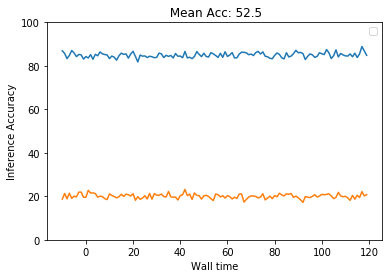

In [342]:
# No retraining
run(a_cfgs["no"], b_cfgs["no"], a_res_alloc=2, b_res_alloc=2)

A inf res: 0.75. A train res 0.75.
B inf res: 0.75. B train res 0.75.
A completion time: 113.33333333333333. B completion time 106.66666666666667.
A inference speed factor: 0.75
B inference speed factor: 0.75
Done. a_mean_acc: 65.57291666666667. b_mean_acc: 23.75. Overall mean acc: 44.661458333333336


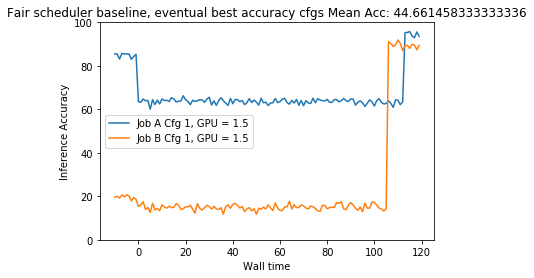

In [343]:
# Fair sharing and picking highest acc hyperparams
run(a_cfgs["high"], b_cfgs["high"], a_res_alloc=1.5, b_res_alloc=1.5, title = "Fair scheduler baseline, eventual best accuracy cfgs",
    labelA = "Job A Cfg 1, GPU = 1.5", labelB = "Job B Cfg 1, GPU = 1.5",
   prepend_sec = PREPEND_SEC)
plt.savefig("schedmot_eventual_best_cfgs.pdf")

# Plot resources:

A inf res: 0.75. A train res 0.75.
B inf res: 0.75. B train res 0.75.
A completion time: 86.66666666666667. B completion time 66.66666666666667.
B will relinquish 0.5
B inference speed factors: 0.75, posttrain: 1.0
A inference speed factor: 0.75
Remaining wall time: 15.0, new_remaining_res_time: 12
A actual completion time: 78
Done. a_mean_acc: 72.9375. b_mean_acc: 46.5. Overall mean acc: 59.71875


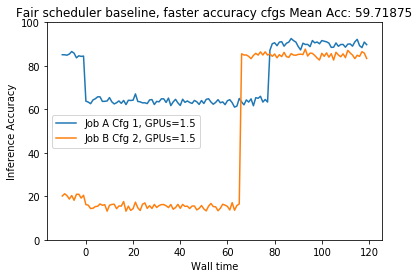

In [351]:
# Fair sharing and picking optimal hyperparams
run2(a_cfgs["low"], b_cfgs["low"], a_res_alloc=1.5, b_res_alloc=1.5, smart_inference=False, title = "Fair scheduler baseline, faster accuracy cfgs", labelA = "Job A Cfg 1, GPUs=1.5", labelB = "Job B Cfg 2, GPUs=1.5",
    prepend_sec = PREPEND_SEC)
plt.savefig("schedmot_optimal_cfgs.pdf")

A inf res: 0.99. A train res 0.010000000000000009.
B inf res: 0.2. B train res 1.8.
A completion time: 6499.9999999999945. B completion time 27.77777777777778.
B will relinquish 1
B inference speed factors: 0.2, posttrain: 1.0
A inference speed factor: 0.99
Remaining wall time: 64.72000000000006, new_remaining_res_time: 64
A actual completion time: 91
Done. a_mean_acc: 85.56374999999998. b_mean_acc: 66.775. Overall mean acc: 76.169375


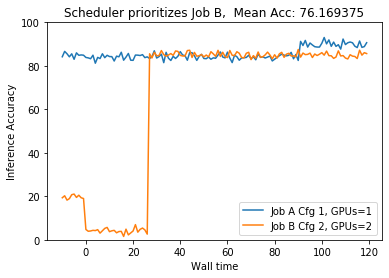

In [347]:
# Prioritizing B and picking optimal hyperparams
run2(a_cfgs["low"], b_cfgs["low"], a_res_alloc=1, b_res_alloc=2, a_inference_split=0.99, b_inference_split=0.1,
     title = "Scheduler prioritizes Job B, ", labelA = "Job A Cfg 1, GPUs=1", labelB = "Job B Cfg 2, GPUs=2",
    prepend_sec = PREPEND_SEC)
plt.savefig("schedmot_prioritization_and_optimal_cfgs.pdf")

# PLot resource maps

106


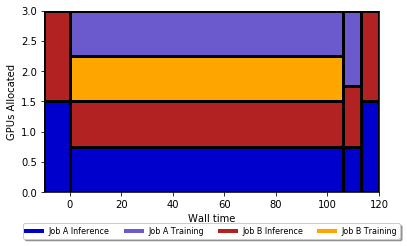

In [394]:
plt.figure()

ax = plt.gca()
errorboxes = []

lw = 3
rects = []


A_TRAIN_TIME = 113-106
B_TRAIN_TIME = 106

col_JobAInf = 'mediumblue'
col_JobATrg = 'slateblue'
col_JobBInf = 'firebrick'
col_JobBTrg = 'orange'

# Till start
rects.append(patches.Rectangle((PREPEND_SEC*-1,0), PREPEND_SEC, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PREPEND_SEC*-1,1.5), PREPEND_SEC, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))

# Till B finishes
PHASE_START = 0
rects.append(patches.Rectangle((PHASE_START, 0), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.75), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 2.25), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till A finishes
PHASE_START += B_TRAIN_TIME
print(PHASE_START)
rects.append(patches.Rectangle((PHASE_START, 0), A_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.75), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.75), A_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 1.75), A_TRAIN_TIME, 1.25,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till period finishes
PHASE_START += A_TRAIN_TIME
REMAIN_TIME = PERIOD-PHASE_START
rects.append(patches.Rectangle((PHASE_START, 0), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))


# Add the patch to the Axes
for rect in rects:
    ax.add_patch(rect)
plt.xlim([-1*PREPEND_SEC,PERIOD])
plt.ylim([0,TOTAL_GPUS])

plt.xlabel('Wall time')
plt.ylabel('GPUs Allocated')

custom_lines = [Line2D([0], [0], color=col_JobAInf, lw=4),
                Line2D([0], [0], color=col_JobATrg, lw=4),
                Line2D([0], [0], color=col_JobBInf, lw=4),
                Line2D([0], [0], color=col_JobBTrg, lw=4)]
ax.legend(custom_lines, ['Job A Inference', 'Job A Training', 'Job B Inference', 'Job B Training'],
         loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5, prop={'size': 8})

plt.subplots_adjust(left=None, bottom=0.25, right=None, top=None, wspace=None, hspace=None)

plt.savefig("schedmot_res_eventual_best_cfgs.pdf")

66


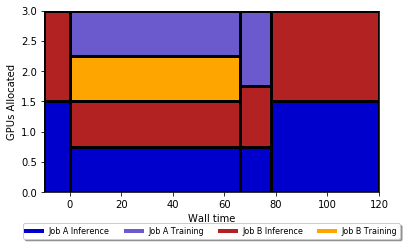

In [395]:
plt.figure()

ax = plt.gca()
errorboxes = []

lw = 3
rects = []


A_TRAIN_TIME = 78-66
B_TRAIN_TIME = 66

col_JobAInf = 'mediumblue'
col_JobATrg = 'slateblue'
col_JobBInf = 'firebrick'
col_JobBTrg = 'orange'

# Till start
rects.append(patches.Rectangle((PREPEND_SEC*-1,0), PREPEND_SEC, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PREPEND_SEC*-1,1.5), PREPEND_SEC, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))

# Till B finishes
PHASE_START = 0
rects.append(patches.Rectangle((PHASE_START, 0), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.75), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 2.25), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till A finishes
PHASE_START += B_TRAIN_TIME
print(PHASE_START)
rects.append(patches.Rectangle((PHASE_START, 0), A_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.75), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.75), A_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 1.75), A_TRAIN_TIME, 1.25,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till period finishes
PHASE_START += A_TRAIN_TIME
REMAIN_TIME = PERIOD-PHASE_START
rects.append(patches.Rectangle((PHASE_START, 0), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))


# Add the patch to the Axes
for rect in rects:
    ax.add_patch(rect)
plt.xlim([-1*PREPEND_SEC,PERIOD])
plt.ylim([0,TOTAL_GPUS])

plt.xlabel('Wall time')
plt.ylabel('GPUs Allocated')

custom_lines = [Line2D([0], [0], color=col_JobAInf, lw=4),
                Line2D([0], [0], color=col_JobATrg, lw=4),
                Line2D([0], [0], color=col_JobBInf, lw=4),
                Line2D([0], [0], color=col_JobBTrg, lw=4)]
ax.legend(custom_lines, ['Job A Inference', 'Job A Training', 'Job B Inference', 'Job B Training'],
         loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5, prop={'size': 8})

plt.subplots_adjust(left=None, bottom=0.25, right=None, top=None, wspace=None, hspace=None)

plt.savefig("schedmot_res_optimal_cfgs.pdf")

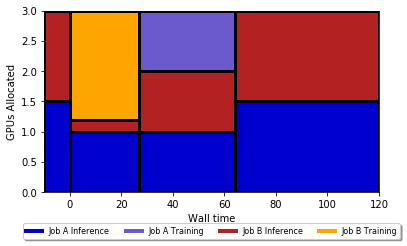

In [396]:
plt.figure()

ax = plt.gca()
errorboxes = []

lw = 3
rects = []


A_TRAIN_TIME = 64
B_TRAIN_TIME = 27

col_JobAInf = 'mediumblue'
col_JobATrg = 'slateblue'
col_JobBInf = 'firebrick'
col_JobBTrg = 'orange'

# Till start
rects.append(patches.Rectangle((PREPEND_SEC*-1,0), PREPEND_SEC, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PREPEND_SEC*-1,1.5), PREPEND_SEC, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))

# Till B finishes
PHASE_START = 0
rects.append(patches.Rectangle((PHASE_START, 0), B_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1), B_TRAIN_TIME, 0.2,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.2), B_TRAIN_TIME, 1.8,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), B_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))


# Till A finishes
PHASE_START += B_TRAIN_TIME
rects.append(patches.Rectangle((PHASE_START, 0), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 2), A_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 2), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till period finishes
PHASE_START =+ A_TRAIN_TIME
REMAIN_TIME = PERIOD-PHASE_START
rects.append(patches.Rectangle((PHASE_START, 0), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))


# Add the patch to the Axes
for rect in rects:
    ax.add_patch(rect)
plt.xlim([-1*PREPEND_SEC,PERIOD])
plt.ylim([0,TOTAL_GPUS])

plt.xlabel('Wall time')
plt.ylabel('GPUs Allocated')

custom_lines = [Line2D([0], [0], color=col_JobAInf, lw=4),
                Line2D([0], [0], color=col_JobATrg, lw=4),
                Line2D([0], [0], color=col_JobBInf, lw=4),
                Line2D([0], [0], color=col_JobBTrg, lw=4)]
ax.legend(custom_lines, ['Job A Inference', 'Job A Training', 'Job B Inference', 'Job B Training'],
         loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5, prop={'size': 8})

plt.subplots_adjust(left=None, bottom=0.25, right=None, top=None, wspace=None, hspace=None)

plt.savefig("schedmot_res_prioritization_and_optimal_cfgs.pdf")